# Project Navigation Guidelines

In [1]:
'''
===================================================
Notebook naming convention for FindMeInside (FMI)
===================================================
Notebook name: [FMI] <Coord/Label> Alg - Exp<experiment_number>, Trial<trial_number>

===================================================
Folder/File naming convention
===================================================
# Folder categorised by Experiment (except Testing folder)
Folder name: Experiment<Experiment_number>

# Each Folder has N files.
# A file is either a 1)Unprocessed Dataset, 2)Processed Dataset, 3)Results dataset, 4) Notebook file
# Each experiment has N trials. (Adjustments to parameters/algorithm are made in each trial)
Files in folder will be named accordingly...

- Raw data point:             E<experiment_number>_Label/Location<location_identifier>_<date>v<version_number>
-- e.g. E1_LabelA_230320v1
- Raw data collection:        E<experiment_number>_All_Raw_<date>v<version_number>
-- e.g. E1_All_Raw_230320v1
- Processed data (if any):    E<experiment_number>_All_Proc_<date>v<version_number>
-- e.g. E1_All_Proc_230320v1
- Resampled data (if any):    E<experiment_number>_resampled_t<trial_number>
-- e.g. E1_resampled_t1
- Results data:               E<experiment_number>_<algorithm>_t<trial_number>_k<number_of_neighbours>
-- e.g. E1_KNN_t1_k37

===================================================
List of experiment(s) & description(s)
===================================================
>> Experiment 1 (Exp1) :11 Sensors {1, ..., 11} , 4 Location Labels {A,B,C,D}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 2 (Exp2) :11 Sensors {1, ..., 11} , 4 Location Coords {(x_A, y_A), ... (x_D, y_D)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 3 (Exp3) : 12 Sensors {0x1, ..., 0xC} , 12 Location Label {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 4 (Exp4) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 5 (Exp5) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Averaged 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 6 (Exp6) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Resampled 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 7 (Exp7) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via FindMeInside Phone App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Averaged 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

'''
None

# Trial Description

In [1]:
exp = 6
trial = 1
'''
Trial 1
Algorithms use calcLocation mechanic
Resampling done within time period of 2s.
'''
None

# Core Libraries

In [2]:
import pandas as pd #from pandas import read_csv, pivot_table
import numpy as np
import math
import operator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# [Exploratory Data Analysis]

# Prepare/Load Relevant Dataset

In [4]:
# Read csv file into dataframe.
csvfile = pd.read_csv('E6_All_Proc_230320v1.csv')
relDf = pd.DataFrame(csvfile)
# print(relDf)
relDf.columns = relDf.columns.str.strip() #strip unintended whitespaces

# print("Columns: ", relDf.columns)
relDf = relDf[['Date','Time', 'ID2', 'RSSI', 'Location']] #select relevant columns
# df = df.drop(columns=['Type', 'ID0', 'ID1', 'Sensor Data', 'Temperature', 'Humidity', 'Raw Data'])
print(relDf)

          Date       Time      ID2  RSSI Location
0      16/3/20   15:14:49   0x0001   192      1,1
1      16/3/20   15:14:49   0x0003   177      1,1
2      16/3/20   15:14:49   0x0004   179      1,1
3      16/3/20   15:14:50   0x0002   189      1,1
4      16/3/20   15:14:51   0x0008   177      1,1
...        ...        ...      ...   ...      ...
52882  19/3/20   15:48:51   0x0009   177    19,13
52883  19/3/20   15:48:51   0x0004   177    19,13
52884  19/3/20   15:48:51   0x0002   177    19,13
52885  19/3/20   15:48:51   0x000B   189    19,13
52886  19/3/20   15:48:51   0x0005   177    19,13

[52887 rows x 5 columns]


# Resample/Reshape Dataset

In [14]:
# Preparation for Date/Time Differences
# ----------------------------------------

# Combine date and time to datetime
readings = relDf.copy()
readings['Datetime'] = pd.to_datetime(readings['Date'].apply(str)+' '+readings['Time']) #create new Datetime field
dateTime = readings['Datetime']
readings = readings.drop(columns=['Datetime'])
readings.insert(0, 'Datetime', dateTime)
readings = readings.drop(columns=['Date','Time'])
readings.tail()

from datetime import datetime as dt
earliestDate = readings.Datetime.dt.date.min()
print(readings.Datetime.dt.date.iloc[-1])
print(earliestDate - readings.Datetime.dt.date.iloc[-1])

# Function that expresses timestamps in seconds.
def time_to_sec(timeArray):
    timeSecArray = []
    for i in range(len(timeArray)):
        seconds = (timeArray[i].hour * 60 + timeArray[i].minute) * 60 + timeArray[i].second
        timeSecArray.append(seconds)
    return(timeSecArray)

# Function that calculates day difference between dates in seconds
def date_to_sec(dateArray):
    dateSecArray = []
    for i in range(len(dateArray)):
        dayDiff = dateArray[i] - earliestDate
        dateSecArray.append(dayDiff.total_seconds())
#     print(i)
    return(dateSecArray)


readings['DateSec'] = date_to_sec(readings.Datetime.dt.date)
readings['TimeSec'] = time_to_sec(readings.Datetime.dt.time)
readings['DatetimeSec'] = readings['DateSec'] + readings['TimeSec']
readings = readings[['DatetimeSec', 'ID2', 'RSSI', 'Location']]

# pd.set_option('display.max_columns', 10)
# pd.set_option('display.min_rows', 50)
# pd.set_option('display.width', 500)

readings.DatetimeSec = (readings.DatetimeSec - readings.DatetimeSec.min()) // 2
time_diff_btw_rows = readings.DatetimeSec.diff().fillna(0)
# print(time_diff_btw_rows)
time_diff_btw_rows -= (time_diff_btw_rows > 1) & (readings.DatetimeSec % 2 > 0)
readings.DatetimeSec -= (time_diff_btw_rows - 1).clip(lower=0).cumsum()
readings.ID2 = readings.ID2.transform(lambda hexadecimal: int(hexadecimal, 16))
resampled_readings = readings.groupby(["DatetimeSec", "Location", "ID2"]).mean().reset_index()
pivoted_readings = pd.pivot_table(resampled_readings, values="RSSI", columns=["ID2"], index=["DatetimeSec", "Location"]).fillna(0)

writeFile = True
if (writeFile == True):
    pivoted_readings.to_csv('E6_resampled_T1.csv')
    print("FILE WRITTEN")

pivoted_readings.head()

2020-03-19
-3 days, 0:00:00
FILE WRITTEN


,ID2,1,2,3,4,5,6,7,8,9,10,11,12
DatetimeSec,Location,,,,,,,,,,,,
0.0,"1,1",192.0,189.0,177.0,179.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,"1,1",193.0,182.0,180.0,0.0,177.0,0.0,0.0,177.0,177.0,0.0,177.0,0.0
2.0,"1,1",191.0,191.0,185.0,184.0,177.0,177.0,0.0,177.0,0.0,177.0,0.0,177.0
3.0,"1,1",195.0,192.0,184.0,182.0,177.0,177.0,177.0,177.0,0.0,0.0,177.0,177.0
4.0,"1,1",194.0,193.0,184.0,187.0,0.0,0.0,177.0,178.0,0.0,0.0,0.0,177.0


In [61]:
resampledDS = pd.read_csv('E6_resampled_T1.csv')
tempSeries = resampledDS['Location']
resampledDS = resampledDS.drop(columns=['Location', 'DatetimeSec'])
resampledDS["Location"] = tempSeries
resampledDS.head()
lastIndex = len(resampledDS)
numCol = len(resampledDS.columns)

ips_data = resampledDS.iloc[:lastIndex, :numCol-1]
# print(ips_data)
ips_label = resampledDS.iloc[:lastIndex, numCol-1:]
# print(ips_labels)

X_test = ips_data.to_numpy()
y_test = ips_label.to_numpy()
print(len(y_test))
y_test

5650


array([['1,1'],
       ['1,1'],
       ['1,1'],
       ...,
       ['19,13'],
       ['19,13'],
       ['19,13']], dtype=object)

In [64]:
trainsetDS = pd.read_csv('E5copy_resampledavg_T1.csv')
tempSeries = trainsetDS['Location']
trainsetDS = trainsetDS.drop(columns=['Location'])
trainsetDS["Location"] = tempSeries
trainsetDS.head()

ips_data2 = trainsetDS.iloc[:lastIndex, :numCol-1]
# print(ips_data)
ips_label2 = trainsetDS.iloc[:lastIndex, numCol-1:]
# print(ips_labels)

X_train = ips_data2.to_numpy()
y_train = ips_label2.to_numpy()
y_train = y_train.reshape(len(y_train),)
print(len(y_train))
y_train

k_value_rootN = math.ceil(math.sqrt(len(X_train)))
print("estimated k value: ", k_value_rootN)
# print("X_test: ", X_test)
# print("y_test: ", y_test)

12
estimated k value:  4


# Parameter Optimisation

# KNN Algorithm - Distance Calculation

In [65]:
#Function calculates euclidean distance between two n-dimensional data instances 
def euclideanDistance(instance1, instance2):
    #handles if instances are lists or tuples:
    instance1 = np.array(instance1) 
    instance2 = np.array(instance2)
    
    '''
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html
    uses 2-norm frobenius norm and returns euclidean distance
    '''
    return np.linalg.norm(instance1 - instance2) #euclidean distance

# KNN Algorithm - Determining Neighbours

In [66]:
#Function finds nearest neighbours; nearest -> smallest euclidean distance
def get_neighbors(training_set, 
                  labels, 
                  test_instance, 
                  k, 
                  distance=euclideanDistance):
    """
    get_neighbors calculates a list of the k nearest neighbors
    of an instance 'test_instance'.
    The list neighbors contains 3-tuples with  
    (index, dist, label)
    where
    index    is the index from the training_set, 
    dist     is the distance between the test_instance and the 
             instance training_set[index]
    distance is a reference to a function used to calculate the 
             distances
    """
    distances = [] #empty distance array
    
    #calculates euclidean distance between test_instance and ALL other instances in training_set
    for index in range(len(training_set)):
        dist = euclideanDistance(test_instance, training_set[index])
        distances.append((training_set[index], dist, labels[index]))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors # The list neighbors contains 3-tuples with (index, dist, label)

In [67]:
# Get Neighbours
outArray = []
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_rootN, 
                              distance=euclideanDistance)
#     print(i,
#           X_test[i],
#           y_test[i],
#           neighbors)
    
    outArray.append([i,
          X_test[i],
          y_test[i],
          neighbors])

out_df = pd.DataFrame(outArray, columns=['i', 'X_test', 'y_test', 'neighbours'])
out_df.head()
# out_df.tail()

,i,X_test,y_test,neighbours
0,0,"[192.0, 189.0, 177.0, 179.0, 0.0, 0.0, 0.0, 0....","[1,1]","[([193.20181409999998, 189.45901640000002, 183..."
1,1,"[193.0, 182.0, 180.0, 0.0, 177.0, 0.0, 0.0, 17...","[1,1]","[([193.20181409999998, 189.45901640000002, 183..."
2,2,"[191.0, 191.0, 185.0, 184.0, 177.0, 177.0, 0.0...","[1,1]","[([193.20181409999998, 189.45901640000002, 183..."
3,3,"[195.0, 192.0, 184.0, 182.0, 177.0, 177.0, 177...","[1,1]","[([193.20181409999998, 189.45901640000002, 183..."
4,4,"[194.0, 193.0, 184.0, 187.0, 0.0, 0.0, 177.0, ...","[1,1]","[([193.20181409999998, 189.45901640000002, 183..."


In [68]:
from collections import Counter
#LOC: outputs for each [x,y] in label, 
#     where (x_n1, y_n1) rep x and y coord of 1st neighbour resp
#     x_out = sum(x_n1, ... x_N) / N, where total neighbours = N
def calcLocation(neighbours): 
    x_out = 0
    y_out = 0
    totalNeighbours = len(neighbours)
    for neighbour in neighbours:
        # handle label (str) to tuple(int, int)
        labeltuple = neighbour[2]
        labeltuple = tuple(map(int, labeltuple.split(',')))
#         print("neighbour label: ", labeltuple)
        x_nb = labeltuple[0]
        y_nb = labeltuple[1]
#         print("x_nb: ", x_nb)
#         print("y_nb: ", y_nb)
        x_out += x_nb
        y_out += y_nb
#         print("x_out: ", x_out)
#         print("y_out: ", y_out)
    return ((x_out/totalNeighbours) , (y_out/totalNeighbours))

In [69]:
print("NON-WEIGHTED POSITION KNN\n")
k_value_knn = k_value_rootN
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
    print("test location: ", testPosTuple)
    print("calculalated location: ", calcLocation(neighbors))
    print("distance error: ", euclideanDistance(testPosTuple, calcLocation(neighbors)))
    print("----------------------------")

NON-WEIGHTED POSITION KNN

test location:  (1, 1)
calculalated location:  (2.5, 5.5)
distance error:  4.743416490252569
----------------------------
test location:  (1, 1)
calculalated location:  (2.5, 7.0)
distance error:  6.18465843842649
----------------------------
test location:  (1, 1)
calculalated location:  (2.5, 7.0)
distance error:  6.18465843842649
----------------------------
test location:  (1, 1)
calculalated location:  (2.5, 5.5)
distance error:  4.743416490252569
----------------------------
test location:  (1, 1)
calculalated location:  (2.5, 5.5)
distance error:  4.743416490252569
----------------------------


In [74]:
k_value_knn = k_value_rootN
writeKNN = True
fileNameKNN = 'E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(k_value_knn)+'.csv'
resultsKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'pred_location', 'label', 'error'])

indexArray = []
dataArray = []
locArray = []
labelArray = []
errorArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
#     print("test location: ", testPosTuple)
#     print("calculalated location: ", calcLocation(neighbors))
#     print("distance error: ", euclideanDistance(testPosTuple, calcLocation(neighbors)))
    
    indexArray.append(i)
    dataArray.append(X_test[i])
    calcLocationRes = calcLocation(neighbors)
    locArray.append(calcLocationRes)
    labelArray.append(y_test[i][0])
    errorArray.append(euclideanDistance(testPosTuple, calcLocationRes))


resultsKNN['index'] = indexArray
resultsKNN['data'] = dataArray
resultsKNN['pred_location'] = locArray
resultsKNN['label'] = labelArray 
resultsKNN['error'] = errorArray

if (writeKNN == True):
    resultsKNN.to_csv(fileNameKNN, index=False)
    print("File "+fileNameKNN+" has been written.")
resultsKNN.head(20)

File E6_KNN_T1_k4.csv has been written.


,index,data,pred_location,label,error
0,0,"[192.0, 189.0, 177.0, 179.0, 0.0, 0.0, 0.0, 0....","(2.5, 5.5)","1,1",4.743416
1,1,"[193.0, 182.0, 180.0, 0.0, 177.0, 0.0, 0.0, 17...","(2.5, 7.0)","1,1",6.184658
2,2,"[191.0, 191.0, 185.0, 184.0, 177.0, 177.0, 0.0...","(2.5, 7.0)","1,1",6.184658
3,3,"[195.0, 192.0, 184.0, 182.0, 177.0, 177.0, 177...","(2.5, 5.5)","1,1",4.743416
4,4,"[194.0, 193.0, 184.0, 187.0, 0.0, 0.0, 177.0, ...","(2.5, 5.5)","1,1",4.743416
5,5,"[194.0, 190.0, 185.0, 183.0, 177.0, 0.0, 177.0...","(5.5, 4.0)","1,1",5.408327
6,6,"[194.0, 191.0, 188.0, 183.0, 178.0, 0.0, 177.0...","(4.0, 5.5)","1,1",5.408327
7,7,"[193.0, 192.0, 185.0, 184.0, 0.0, 0.0, 177.0, ...","(5.5, 4.0)","1,1",5.408327
8,8,"[194.0, 0.0, 180.0, 0.0, 178.0, 0.0, 0.0, 177....","(8.5, 8.5)","1,1",10.606602
9,9,"[191.0, 185.0, 181.0, 181.0, 0.0, 0.0, 177.0, ...","(5.5, 4.0)","1,1",5.408327


# Weighted KNN

# Distance Weighted KNN

In [79]:
def calcLocationDistW(neighbours): 
    x_out = 0
    y_out = 0
    total_dist = 0
#     cnt = 1
    for neighbour in neighbours:
#         print("Neighour #: ", cnt)
        # handle label (str) to tuple(int, int)
        labeltuple = neighbour[2]
        labeltuple = tuple(map(int, labeltuple.split(',')))
        # distance
        dist_nb = neighbour[1]
        total_dist += ( 1 / (1 if dist_nb == 0 else dist_nb) )
#         print("Neighbour distance: ", dist_nb)
#         print("Total distance: ", total_dist)
        x_nb = labeltuple[0]
        y_nb = labeltuple[1]
#         print("x_nb: ", x_nb)
#         print("y_nb: ", y_nb)
        x_out += x_nb*( 1 / (1 if dist_nb == 0 else dist_nb) )
        y_out += y_nb*( 1 / (1 if dist_nb == 0 else dist_nb) )
#         print("x_out: ", x_out)
#         print("y_out: ", y_out)
#         cnt += 1
    return ( (x_out/(1 if total_dist == 0 else total_dist)) ,
             (y_out/(1 if total_dist == 0 else total_dist)) )


In [80]:
k_value_dwknn = k_value_rootN
testRange = 20
for i in range(testRange):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
    print("test location: ", testPosTuple)
    print("calculalated location: ", calcLocationDistW(neighbors))
    print("distance error: ", euclideanDistance(testPosTuple, calcLocationDistW(neighbors)))
    print("---------------------------------------------------------")

test location:  (1, 1)
calculalated location:  (2.4885697444680503, 5.501578063993976)
distance error:  4.741312576742587
---------------------------------------------------------
test location:  (1, 1)
calculalated location:  (2.48305396684302, 6.99451985929001)
distance error:  6.175250392655438
---------------------------------------------------------
test location:  (1, 1)
calculalated location:  (2.4876930052368182, 6.993398073299386)
distance error:  6.175277398049366
---------------------------------------------------------
test location:  (1, 1)
calculalated location:  (2.494165545950763, 5.501343295719565)
distance error:  4.742849580645144
---------------------------------------------------------
test location:  (1, 1)
calculalated location:  (2.4849195742687, 5.504856876730978)
distance error:  4.743281735452441
---------------------------------------------------------
test location:  (1, 1)
calculalated location:  (5.47280905967315, 3.9859692715986466)
distance error:  5.37

In [82]:
k_value_dwknn = 1
writeDWKNN = True
fileNameDWKNN = 'E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(k_value_dwknn)+'.csv'
resultsDWKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'pred_location', 'label', 'error'])

indexArray = []
dataArray = []
locArray = []
labelArray = []
errorArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
#     print("test location: ", testPosTuple)
#     print("calculalated location: ", calcLocationDistW(neighbors))
#     print("distance error: ", euclideanDistance(testPosTuple, calcLocationDistW(neighbors)))
    
    indexArray.append(i)
    dataArray.append(X_test[i])
    locArray.append(calcLocationDistW(neighbors))
    labelArray.append(y_test[i][0])
    errorArray.append(euclideanDistance(testPosTuple, calcLocationDistW(neighbors)))


resultsDWKNN['index'] = indexArray
resultsDWKNN['data'] = dataArray
resultsDWKNN['pred_location'] = locArray
resultsDWKNN['label'] = labelArray 
resultsDWKNN['error'] = errorArray

if (writeDWKNN == True):
    resultsDWKNN.to_csv(fileNameDWKNN, index=False)
    print("File "+fileNameDWKNN+" has been written.")
    
resultsDWKNN.head(20)

File E6_DWKNN_T1_k1.csv has been written.


,index,data,pred_location,label,error
0,0,"[192.0, 189.0, 177.0, 179.0, 0.0, 0.0, 0.0, 0....","(1.0, 1.0)","1,1",0.0
1,1,"[193.0, 182.0, 180.0, 0.0, 177.0, 0.0, 0.0, 17...","(1.0, 1.0)","1,1",0.0
2,2,"[191.0, 191.0, 185.0, 184.0, 177.0, 177.0, 0.0...","(1.0, 1.0)","1,1",0.0
3,3,"[195.0, 192.0, 184.0, 182.0, 177.0, 177.0, 177...","(1.0, 1.0)","1,1",0.0
4,4,"[194.0, 193.0, 184.0, 187.0, 0.0, 0.0, 177.0, ...","(1.0, 1.0)","1,1",0.0
5,5,"[194.0, 190.0, 185.0, 183.0, 177.0, 0.0, 177.0...","(1.0, 1.0)","1,1",0.0
6,6,"[194.0, 191.0, 188.0, 183.0, 178.0, 0.0, 177.0...","(1.0, 1.0)","1,1",0.0
7,7,"[193.0, 192.0, 185.0, 184.0, 0.0, 0.0, 177.0, ...","(1.0, 1.0)","1,1",0.0
8,8,"[194.0, 0.0, 180.0, 0.0, 178.0, 0.0, 0.0, 177....","(1.0, 13.0)","1,1",12.0
9,9,"[191.0, 185.0, 181.0, 181.0, 0.0, 0.0, 177.0, ...","(1.0, 1.0)","1,1",0.0


# Data Analysis via Visualisation

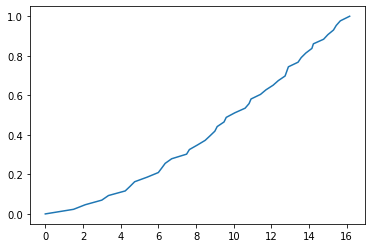

In [53]:
DataKNN = pd.read_csv('E6_KNN_T1_k4.csv')
# Find the unique values

# unique_values = np.sort(pd.Series)
# Make the rank array for these sorted and unique values in the dataset -
# ranks = np.arange(0,len(unique_values))/(len(unique_values)-1)
# Plot unique_values vs ranks

error = DataKNN['error']
## sort the unique values using pandas unique function
knn_error = np.sort(error.unique())
knn_cdf = np.arange(0,len(knn_error),step=1)/(len(knn_error)-1)

## plotting    
plt.plot(knn_error,knn_cdf)
plt.show()

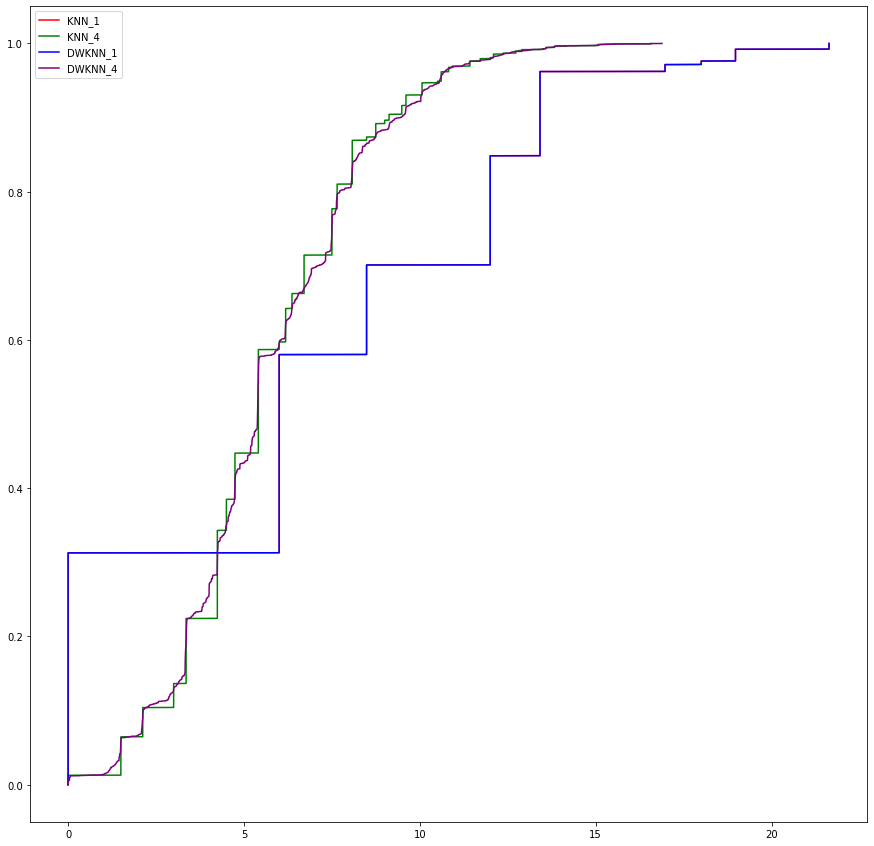

MEDIAN ERROR:
KNNcomp1      6.000000
KNNcomp2      5.408327
DWKNNcomp1    6.000000
DWKNNcomp2    5.385892
dtype: float64


In [83]:
fig= plt.figure(figsize=(15,15))
medErrorDf = pd.DataFrame(index = range(0,len(X_test)))

KNN_kcomp1 = pd.read_csv('E6_KNN_T1_k1.csv')
error = KNN_kcomp1['error']
medErrorDf['KNNcomp1'] = error
knn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp1_error),step=1)/(len(knn_kcomp1_error)-1)
## plotting    
plt.plot(knn_kcomp1_error,cdf, "red", label = "KNN_1")

KNN_kcomp2 = pd.read_csv('E6_KNN_T1_k4.csv')
error = KNN_kcomp2['error']
medErrorDf['KNNcomp2'] = error
knn_kcomp2_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp2_error),step=1)/(len(knn_kcomp2_error)-1)
## plotting    
plt.plot(knn_kcomp2_error,cdf, "green", label = "KNN_4")

DWKNN_kcomp1 = pd.read_csv('E6_DWKNN_T1_k1.csv')
error = DWKNN_kcomp1['error']
medErrorDf['DWKNNcomp1'] = error
dwknn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp1_error),step=1)/(len(dwknn_kcomp1_error)-1)
## plotting    
plt.plot(dwknn_kcomp1_error,cdf, "blue", label = "DWKNN_1")

DWKNN_kcomp2 = pd.read_csv('E6_DWKNN_T1_k4.csv')
error = DWKNN_kcomp2['error']
medErrorDf['DWKNNcomp2'] = error
dwknn_kcomp2_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp2_error),step=1)/(len(dwknn_kcomp2_error)-1)
## plotting
plt.plot(dwknn_kcomp2_error,cdf, "purple", label = "DWKNN_4")

# additional plot params
plt.legend(loc='best', fontsize = 10)
plt.show()

print("MEDIAN ERROR:")
print(medErrorDf.median())